This is my revised kernel inspired by Chau Ngoc Huynh's kernel (3.699).

**New Update : Application of Interaction on Categorical Variables followed by Stacking using Bayesian Ridge on Stratified K Folds**

In [36]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
gc.collect()
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [37]:
#Add All the Models Libraries

# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

In [38]:
# to make this notebook's output stable across runs
np.random.seed(123)
gc.collect()
# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [39]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [40]:
train = reduce_mem_usage(pd.read_csv('../input/train.csv',parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('../input/test.csv', parse_dates=["first_active_month"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [41]:
train.shape

(201917, 6)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int8
feature_2             201917 non-null int8
feature_3             201917 non-null int8
target                201917 non-null float16
dtypes: datetime64[ns](1), float16(1), int8(3), object(1)
memory usage: 4.0+ MB


Text(0.5,0,'Customer Loyality (Skewed)')

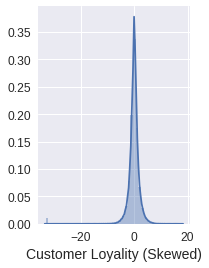

In [43]:
plt.subplot(1, 2, 2)
sns.distplot(train.target, kde=True, fit = norm)
plt.xlabel('Customer Loyality (Skewed)')

In [44]:
# Now extract the month, year, day, weekday
train["month"] = train["first_active_month"].dt.month
train["year"] = train["first_active_month"].dt.year
train['week'] = train["first_active_month"].dt.weekofyear
train['dayofweek'] = train['first_active_month'].dt.dayofweek
train['days'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
train['quarter'] = train['first_active_month'].dt.quarter
train['is_month_start'] = train['first_active_month'].dt.is_month_start

#Interaction Variables
train['days_feature1'] = train['days'] * train['feature_1']
train['days_feature2'] = train['days'] * train['feature_2']
train['days_feature3'] = train['days'] * train['feature_3']

test["month"] = test["first_active_month"].dt.month
test["year"] = test["first_active_month"].dt.year
test['week'] = test["first_active_month"].dt.weekofyear
test['dayofweek'] = test['first_active_month'].dt.dayofweek
test['days'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
test['quarter'] = test['first_active_month'].dt.quarter
test['is_month_start'] = test['first_active_month'].dt.is_month_start

#Interaction Variables
test['days_feature1'] = test['days'] * train['feature_1']
test['days_feature2'] = test['days'] * train['feature_2']
test['days_feature3'] = test['days'] * train['feature_3']

Now we will try to extract more features from Transactions Data

In [45]:
# Taking Reference from Other Kernels
def aggregate_transaction_hist(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max', 'var'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique']
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [46]:
transactions = reduce_mem_usage(pd.read_csv('../input/historical_transactions.csv'))
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [47]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['quarter'] = transactions['purchase_date'].dt.quarter
transactions['is_month_start'] = transactions['purchase_date'].dt.is_month_start
transactions['month_diff'] = ((datetime.datetime.today() - transactions['purchase_date']).dt.days)//30
transactions['month_diff'] += transactions['month_lag']

#impute missing values - This is now excluded.
transactions['category_2'] = transactions['category_2'].fillna(1.0,inplace=True)
transactions['category_3'] = transactions['category_3'].fillna('A',inplace=True)
transactions['merchant_id'] = transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

transactions['category_3'] = transactions['category_3'].map({'A':0, 'B':1, 'C':2})
gc.collect()

263

In [48]:
agg_func = {
        'mean': ['mean'],
    }
for col in ['category_2','category_3']:
    transactions[col+'_mean'] = transactions['purchase_amount'].groupby(transactions[col]).agg('mean')
    transactions[col+'_max'] = transactions['purchase_amount'].groupby(transactions[col]).agg('max')
    transactions[col+'_min'] = transactions['purchase_amount'].groupby(transactions[col]).agg('min')
    transactions[col+'_var'] = transactions['purchase_amount'].groupby(transactions[col]).agg('var')
    agg_func[col+'_mean'] = ['mean']
    
gc.collect()

168

In [49]:
merge_trans = aggregate_transaction_hist(transactions, prefix='hist_')
del transactions
gc.collect()
train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
del merge_trans
gc.collect()

56

In [50]:
train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,week,dayofweek,days,quarter,is_month_start,days_feature1,days_feature2,days_feature3,hist_transactions_count,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_mean,hist_month_diff_min,hist_month_diff_max,hist_month_diff_var,hist_weekend_sum,hist_weekend_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_1_max,hist_category_1_min,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_card_id_size,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,6,2017,22,3,245,2,True,1225,490,245,260,2018-02-25 09:31:15,2017-06-27 14:18:08,10.219231,10,11,0.171830,90,0.346154,247,0.950000,0,0.000000,0,0,-165.968735,-0.638341,2.258394,-0.739395,0.212139,4,0.015385,1,0,0.123314,0,-8,-3.911538,5.748901,260,9,23,35,7,2,21,41
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,1,2017,52,6,396,1,True,1584,396,0,350,2018-01-31 22:31:09,2017-01-06 16:29:42,11.231429,11,12,0.178379,132,0.377143,339,0.968571,31,0.088571,1,0,-210.006332,-0.600018,4.630300,-0.742400,0.384967,543,1.551429,10,-1,1.510777,0,-12,-5.031429,14.477519,350,12,24,50,7,2,24,57


In [51]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (datetime.datetime.today() - train['hist_purchase_date_max']).dt.days
train['hist_purchase_date_uptomin'] = (datetime.datetime.today() - train['hist_purchase_date_min']).dt.days
train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9
gc.collect()


187

In [52]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (datetime.datetime.today() - test['hist_purchase_date_max']).dt.days
test['hist_purchase_date_uptomin'] = (datetime.datetime.today() - test['hist_purchase_date_min']).dt.days

test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9

gc.collect()

75

In [53]:
# Taking Reference from Other Kernels
def aggregate_transaction_new(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max', 'var'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique']
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [54]:
# Now extract the data from the new transactions
new_transactions = reduce_mem_usage(pd.read_csv('../input/new_merchant_transactions.csv'))
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})

Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [55]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
new_transactions['quarter'] = new_transactions['purchase_date'].dt.quarter
new_transactions['is_month_start'] = new_transactions['purchase_date'].dt.is_month_start
new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

gc.collect()

#impute missing values
new_transactions['category_2'] = new_transactions['category_2'].fillna(1.0,inplace=True)
new_transactions['category_3'] = new_transactions['category_3'].fillna('A',inplace=True)
new_transactions['merchant_id'] = new_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

new_transactions['category_3'] = new_transactions['category_3'].map({'A':0, 'B':1, 'C':2}) 

aggs = {
        'mean': ['mean'],
    }

for col in ['category_2','category_3']:
    new_transactions[col+'_mean'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('mean')
    new_transactions[col+'_max'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('max')
    new_transactions[col+'_min'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('min')
    new_transactions[col+'_var'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('var')
    aggs[col+'_mean'] = ['mean']

gc.collect()

175

In [56]:
merge_new = aggregate_transaction_new(new_transactions, prefix='new_')
del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
del merge_new

gc.collect()

35

In [57]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['new_purchase_date_max'] = pd.to_datetime(train['new_purchase_date_max'])
train['new_purchase_date_min'] = pd.to_datetime(train['new_purchase_date_min'])
train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['new_card_id_size']
train['new_purchase_date_uptonow'] = (datetime.datetime.today() - train['new_purchase_date_max']).dt.days
train['new_purchase_date_uptomin'] = (datetime.datetime.today() - train['new_purchase_date_min']).dt.days
train['new_first_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9

#Feature Engineering - Adding new features inspired by Chau's first kernel
test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
test['new_purchase_date_uptonow'] = (datetime.datetime.today() - test['new_purchase_date_max']).dt.days
test['new_purchase_date_uptomin'] = (datetime.datetime.today() - test['new_purchase_date_min']).dt.days
test['new_first_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9
    
#added new feature - Interactive
train['card_id_total'] = train['new_card_id_size'] + train['hist_card_id_size']
train['purchase_amount_total'] = train['new_purchase_amount_sum'] + train['hist_purchase_amount_sum']

test['card_id_total'] = test['new_card_id_size'] + test['hist_card_id_size']
test['purchase_amount_total'] = test['new_purchase_amount_sum'] + test['hist_purchase_amount_sum']

gc.collect()

178

In [58]:
# Now check the shape of Train and Test Data
train.shape

(201917, 102)

In [59]:
train = train.drop(['card_id', 'first_active_month'], axis = 1)
test = test.drop(['card_id', 'first_active_month'], axis = 1)

Detect and Correct Outliers

In [60]:
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [61]:
for features in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([features])['outliers'].mean()
    train[features] = train[features].map(order_label)
    test[features] =  test[features].map(order_label)

In [62]:
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in ['target','outliers']] #features used for FFM
cat_features = [c for c in df_train_columns if 'feature_' in c]  #categories used for FFM 


In [63]:
target = train['target']
del train['target']

Apply Light GBM Modelling Technique with Stratified K Folds enumerated on training set and outliers 

In [64]:
import lightgbm as lgb

param = {'num_leaves': 31,
         'min_data_in_leaf': 27, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1231]	training's rmse: 3.2405	valid_1's rmse: 3.66328
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[995]	training's rmse: 3.28769	valid_1's rmse: 3.64885
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[695]	training's rmse: 3.34767	valid_1's rmse: 3.66755
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1171]	training's rmse: 3.25874	valid_1's rmse: 3.63893
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1281]	training's rmse: 3.23376	valid_1's rmse: 3.65467


3.654671099683132

Feature Importance - Stratified K Folds Technique

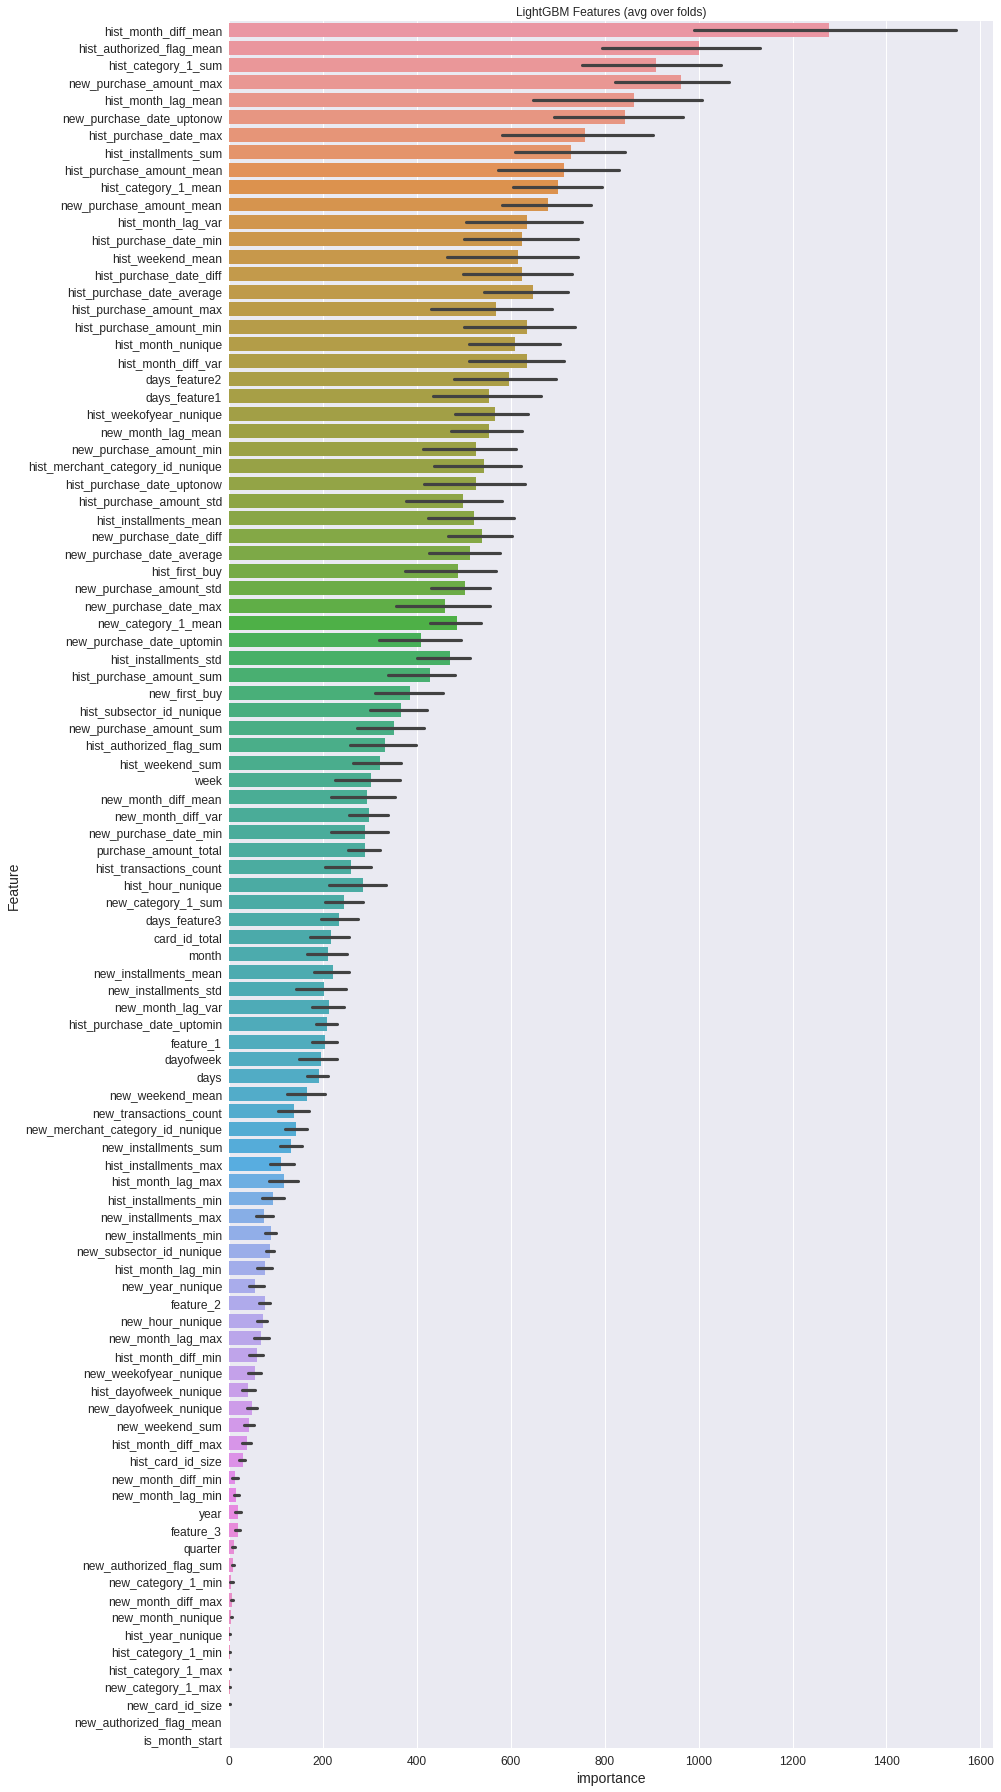

In [65]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [66]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
cat_features = [c for c in features if 'feature_' in c]

Apply Light GBM Modelling Technique with K Folds enumerated on training set and Target 

In [67]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 27, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_features)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_features)

    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][features], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[features], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1131]	training's rmse: 3.25991	valid_1's rmse: 3.66039
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1099]	training's rmse: 3.2296	valid_1's rmse: 3.81493
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[726]	training's rmse: 3.37372	valid_1's rmse: 3.56554
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[894]	training's rmse: 3.3155	valid_1's rmse: 3.62555
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[838]	training's rmse: 3.33628	valid_1's rmse: 3.61283
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[878]	training's rmse: 3.29527	valid_1's rmse: 3.73437
fold 6
Training until validation scores 

Feature Importance - Stratified K Folds

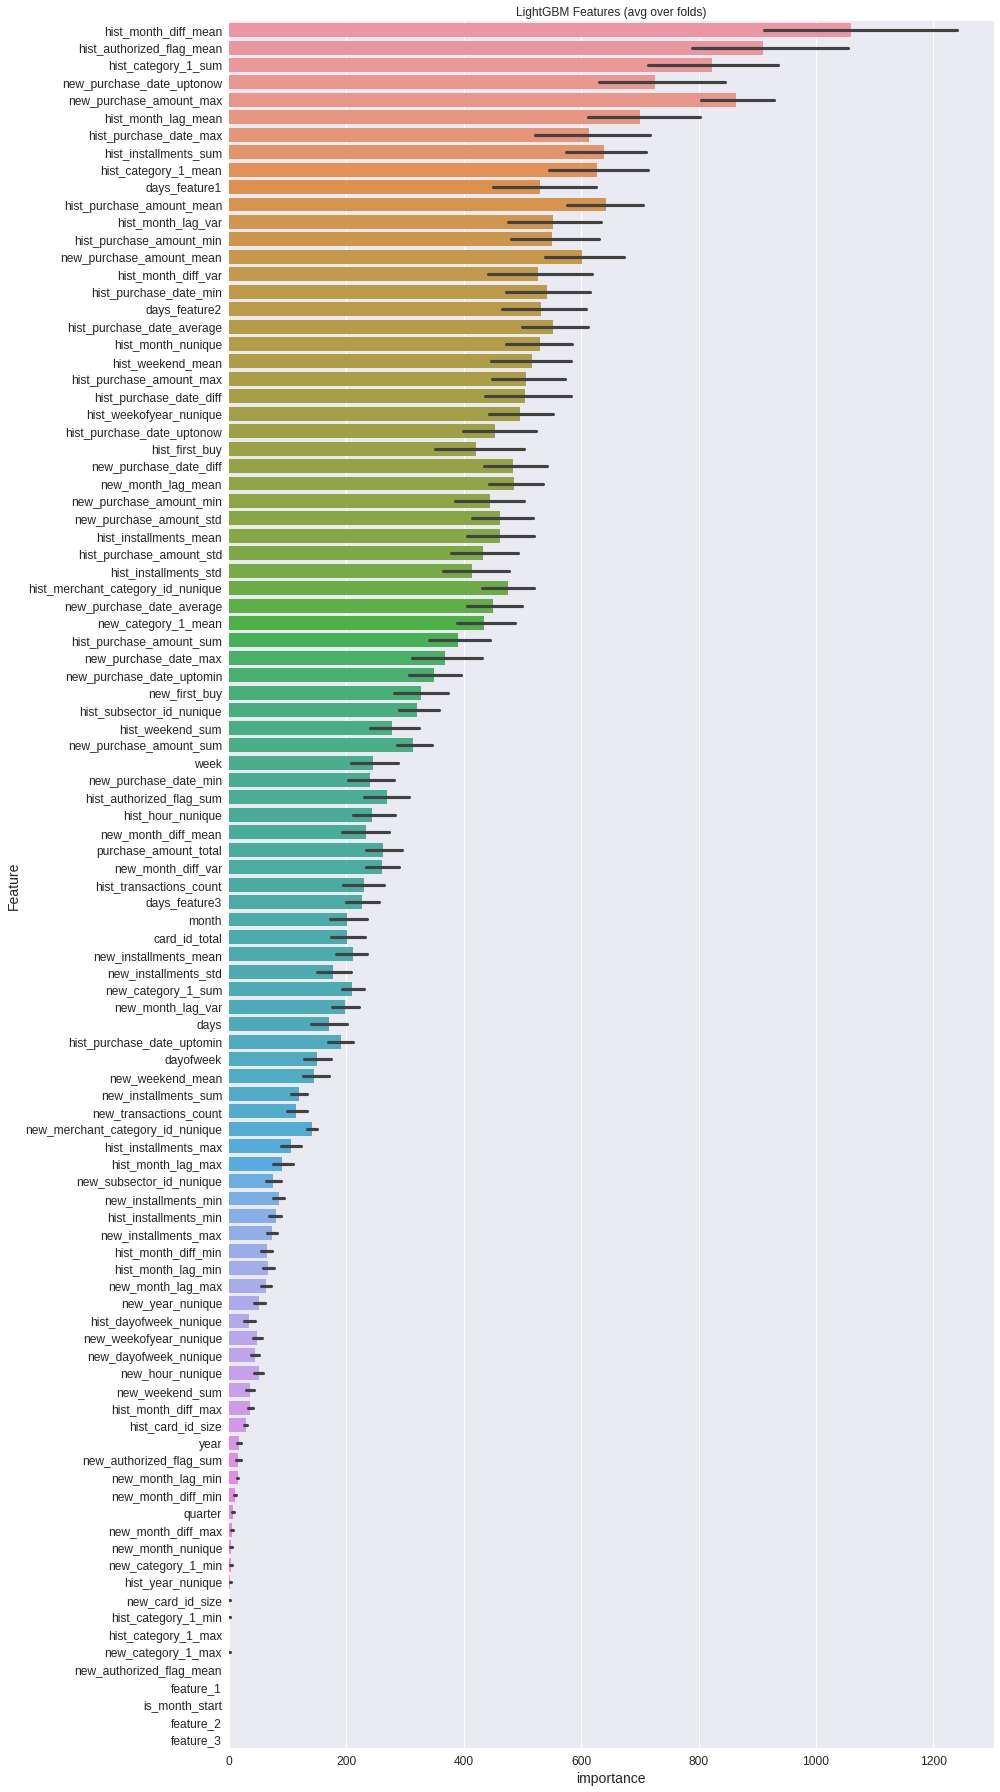

In [68]:
cols = (feature_importance_df_2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_2.loc[feature_importance_df_2.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

Stacking the models together.

In [69]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))


fold 0
fold 1
fold 2
fold 3
fold 4


3.6519727094915417

Final Predictions and Submission File.

In [70]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions_3
sample_submission.to_csv('submission_ashish_lgbm.csv', index=False)